In [1]:
# Import modules 
import sys
from os import getcwd
from os.path import dirname
path = dirname(dirname(getcwd()))
sys.path.append(path)

from MintPy.interpret_toolkit import InterpretToolkit
from MintPy.utils import combine_top_features
import pandas as pd
import numpy as np
import pickle
from joblib import load

In [2]:
#
# LOADING THE MODEL OBJECTS AND THEIR TRAINING EXAMPLES 
#
# Define target feature
TARGET_COLUMN = 'cat_rt'

# Load the model objects. In this case, we are using 3 
# popular models availabe in scikit-learn 
model_fname = ['RandomForest.pkl', 'LogisticRegression.pkl', 'GradientBoostingClassifier.pkl']
model_objs = [load(fname) for fname in model_fname]

# Load the training dataset 
data  = pd.read_csv('example_data.csv')
targets = data[TARGET_COLUMN].values

# only want to use these columns below
cols_to_use = ['dllwave_flux', 'dwpt2m', 'fric_vel', 'gflux', 'high_cloud',
            'lat_hf', 'low_cloud', 'mid_cloud', 'sat_irbt', 'sens_hf',
            'sfcT_hrs_ab_frez', 'sfcT_hrs_bl_frez', 'sfc_rough', 'sfc_temp',
            'swave_flux','temp2m', 'tmp2m_hrs_ab_frez', 'tmp2m_hrs_bl_frez',
            'tot_cloud', 'uplwav_flux','vbd_flux', 'vdd_flux','wind10m',
            'date_marker', 'urban','rural','d_ground','d_rad_d','d_rad_u',
            'hrrr_dT']

units = ['W/m2', 'C', 'm/s', 'W/m2', '%', 'W/m2', '%', '%', 'C', 'W/m2', 'hrs', 'hrs', 
         'unitless','C', 'W/m2', 'C', 'hrs', 'hrs', '%', 'W/m2', 
         'W/m2', 'W/m2', 'm/s', 'days', 'unitless', 'unitless', 'W/m2', 
         'W/m2', 'W/m2', 'C']

feature_units = {c : u for c,u in zip(cols_to_use, units)}

# get predictor subset of dataframe (only the predictors used in training the model)
examples = data[cols_to_use]

/Users/Home/.conda/envs/deep/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/Home/.conda/envs/deep/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.tree.tree module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.tree. Anything that cannot be imported from sklearn.tree is now part of the private API.
  warnings.warn(message, FutureWarning)


# Initializing InterpretToolkit

To initialize `InterpretToolkit`, requires a model object (e.g., a trained sci-kit learn model object) or a list of model objects and examples and targets to evalute the model(s) on. `examples` and `targets` can be `pandas.DataFrame` or `numpy.array`, but if you are using arrays, then you must provide the feature names. 

In [3]:
myInterpreter = InterpretToolkit(model=model_objs, 
                             examples=examples, 
                             targets=targets,
                                )

# Permutation Importance

A first step in model interpretability is determining feature ranking. A popular model-agnostic method for determining predictor ranking is the permutation importance method. The permutation importance calculations in MintPy are performed by a stripped-down version of PermutationImportance (see https://permutationimportance.readthedocs.io/en/latest/ for additional details). In this example, we want the top 5 predictors as determined by the multipass permutation importance method (SOURCE). We are using the AUC as the error metric, but MintPy also supports area under the performance diagram curve (AUPDC) and brier skill score (BSS). 
 
Additional options for permutation importance include: 
* Performing bootstraping for confidence interval on predictor ranking (`nbootstrap`)
* Using multiple processors for parallelization (`njobs`)


In [4]:
# Calculate the predictor ranking using the permutation importance for each model
results = myInterpreter.permutation_importance(
                                               n_vars=4, 
                                               evaluation_fn='auc', 
                                               nbootstrap=1, 
                                               subsample = 1.0,
                                               njobs=3
                                              )

Processing RandomForestClassifier...
Using 3 of processors to compute importance...
Starting on the important variable 1 out of 4...
Starting on the important variable 2 out of 4...
Starting on the important variable 3 out of 4...
Starting on the important variable 4 out of 4...
Processing LogisticRegression...
Using 3 of processors to compute importance...
Starting on the important variable 1 out of 4...
Starting on the important variable 2 out of 4...
Starting on the important variable 3 out of 4...
Starting on the important variable 4 out of 4...
Processing GradientBoostingClassifier...
Using 3 of processors to compute importance...
Starting on the important variable 1 out of 4...
Starting on the important variable 2 out of 4...
Starting on the important variable 3 out of 4...
Starting on the important variable 4 out of 4...


In [5]:
# There is a built-in method to return a list of the top features for each model

important_vars = myInterpreter.get_top_feature(results, multipass=True)
print(important_vars)

# Since permutation importance can be a time-consuming for multiple predictors over a large dataset,
# MintPy also have a built-in function for saving the results 

# And a function for reloading the file and appropriately setting it as a class attribute 
# for the plotting function. 

important_vars = combine_top_features(important_vars, nvars=5)

{'RandomForestClassifier': ['dllwave_flux', 'dwpt2m', 'fric_vel', 'gflux'], 'LogisticRegression': ['dllwave_flux', 'sfcT_hrs_ab_frez', 'mid_cloud', 'dwpt2m'], 'GradientBoostingClassifier': ['dllwave_flux', 'dwpt2m', 'swave_flux', 'fric_vel']}


In [6]:
"""
myInterpreter.plot_importance(multipass=True, 
                              metric = "Training AUC",
                              num_vars_to_plot=5)
"""
# Fix the axis labelling for cases with only one panel!!!

'\nmyInterpreter.plot_importance(multipass=True, \n                              metric = "Training AUC",\n                              num_vars_to_plot=5)\n'

# Partial Dependence Plots

Once we known what features are important, we explore their functional relationship with the target variable. MintPy has a built-in function to take the important features from multiple model turn it into a single list with any duplicate features removed. 

Using 3 processors...


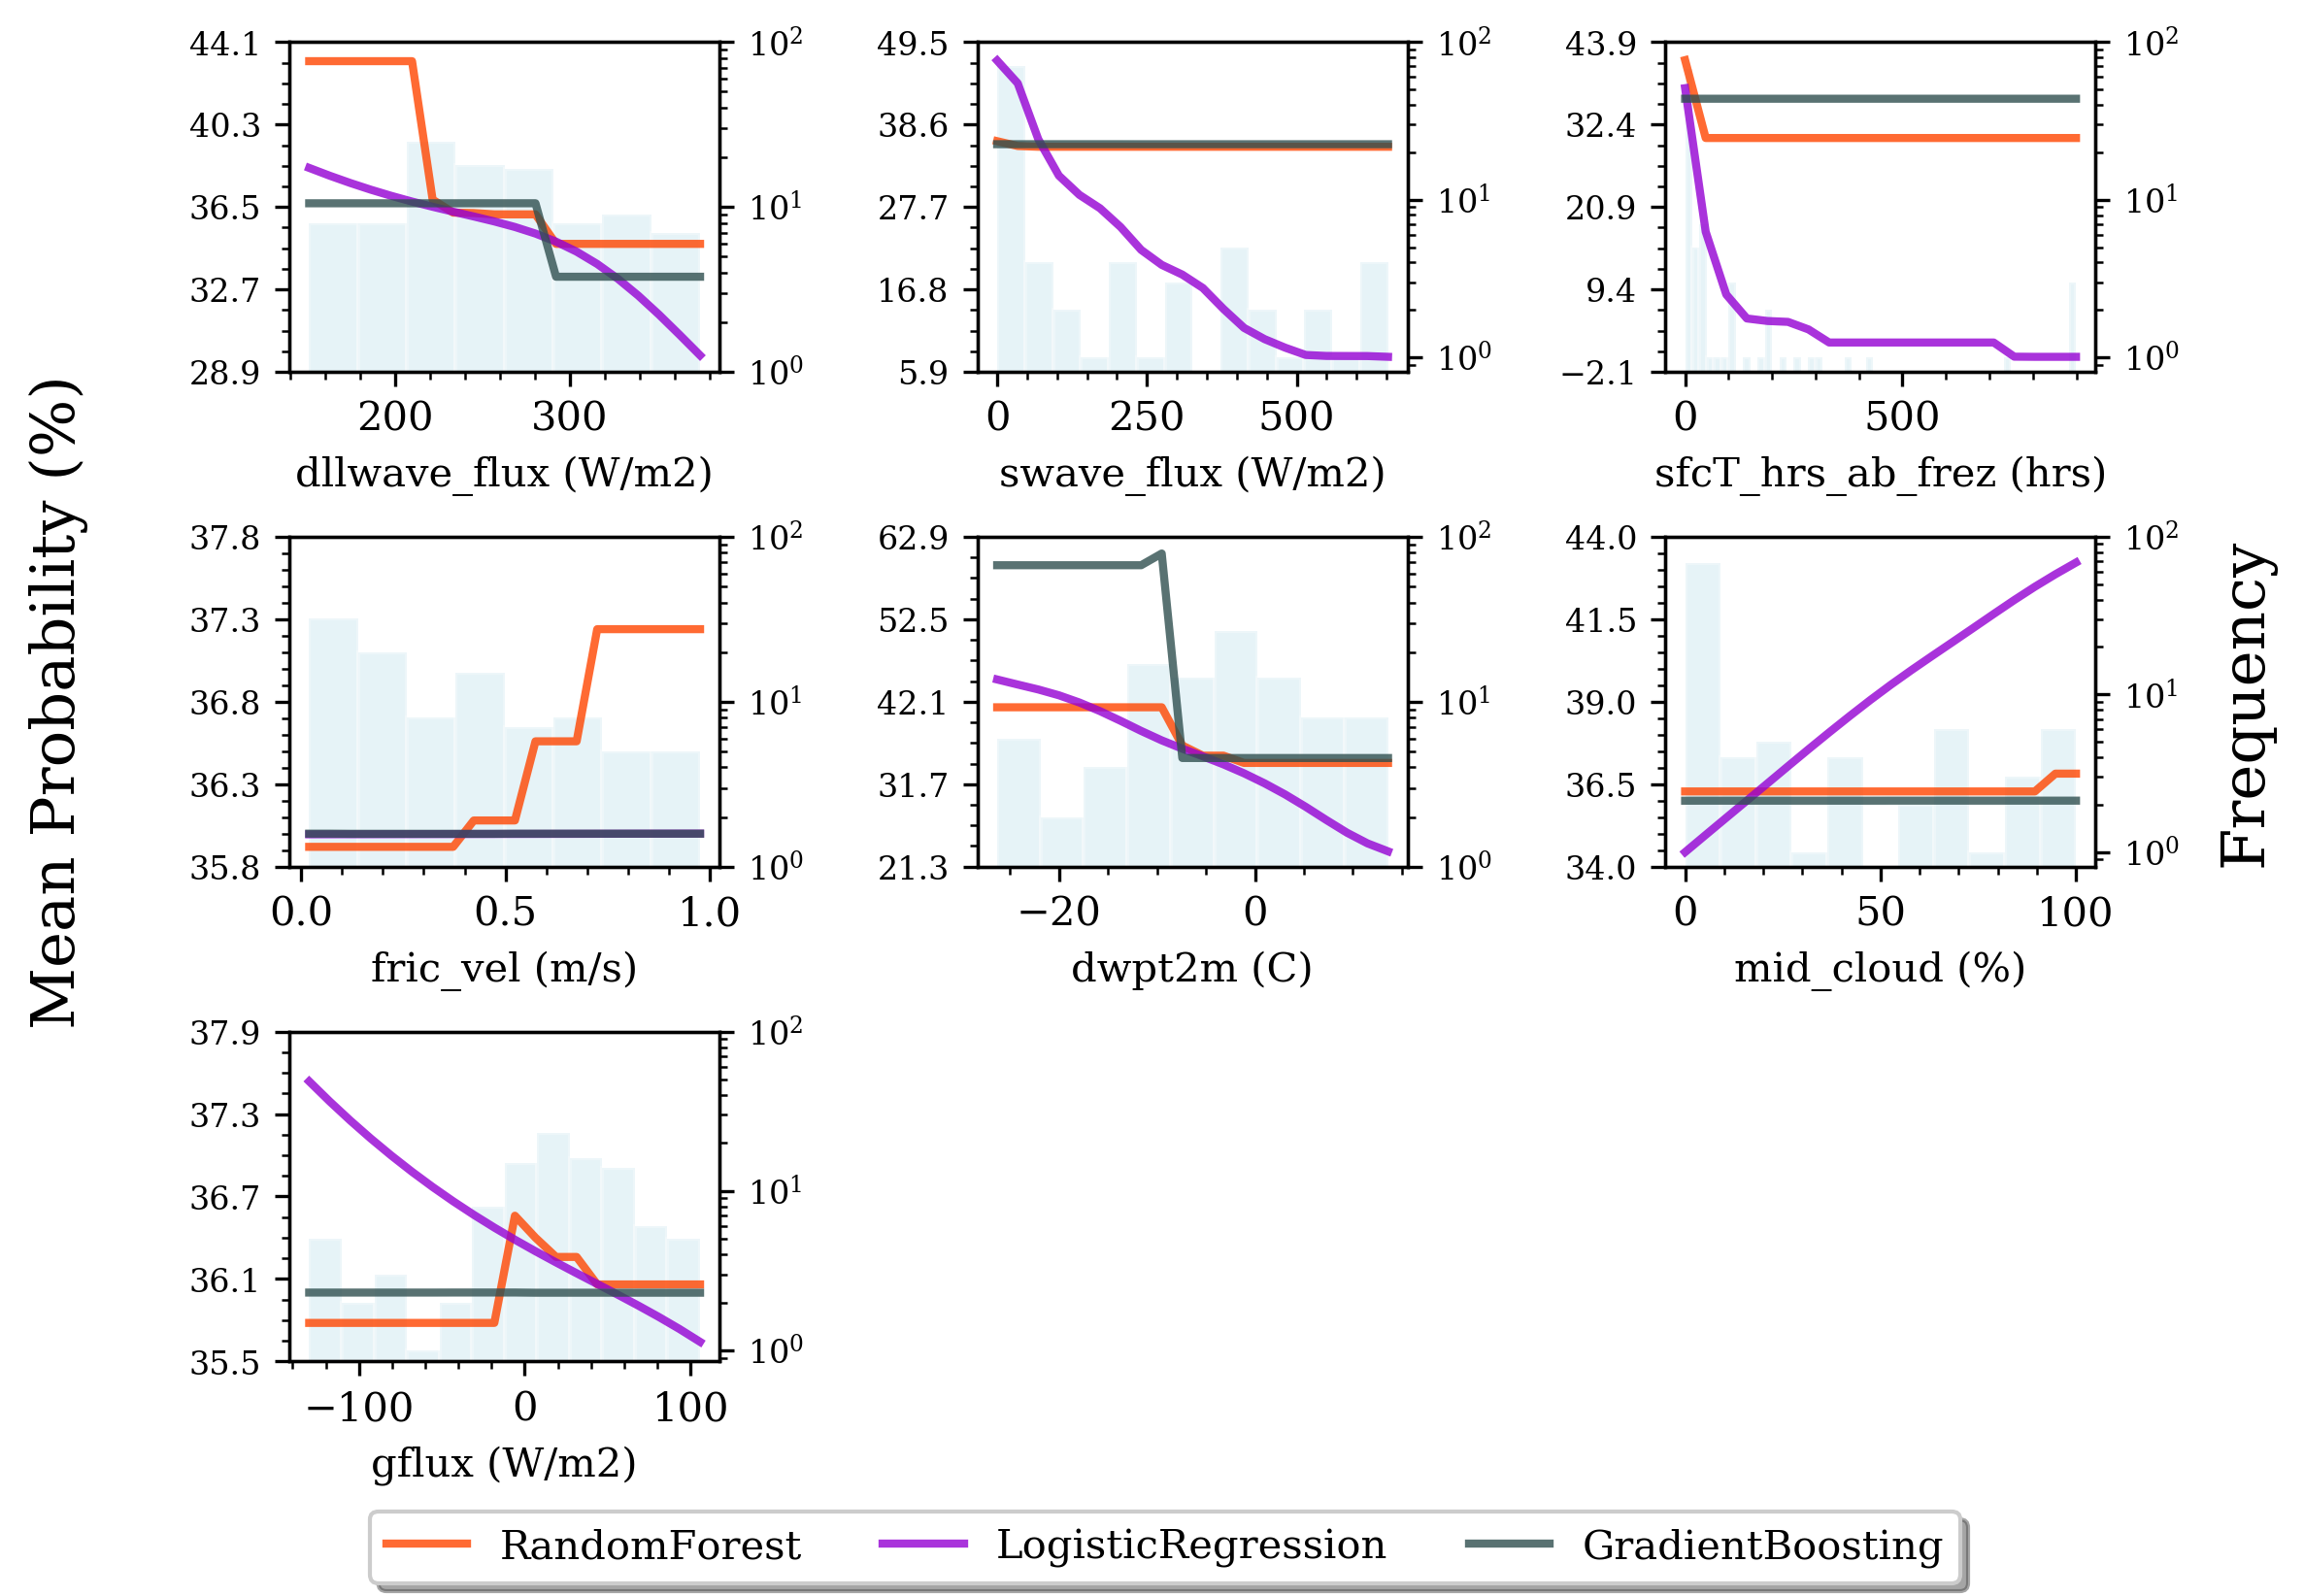

In [7]:
myInterpreter.run_pd(features=important_vars, nbootstrap=1, subsample=1.0, njobs=3)
fig, axes = myInterpreter.plot_pd(feature_units=feature_units)

# Add a functionality for units to be included in the x-axis labelling 
# Add some functionality to generate automatically generate user-friendly right y ticks marks
# Add ability to unnormalize data for the background histogram 
# Fix the units to be 'pretty'

2020-06-01 21:12:52.660 | DEBUG    | ale:_first_order_ale_quant:360 - Quantiles: [-38.09550476 -15.71612549 -10.57272339  -8.00036621  -5.81896973
  -2.82852173  -1.1446228    0.21728516   2.48110962   8.50875854
  21.5017395 ].
2020-06-01 21:12:52.906 | DEBUG    | ale:_ax_quantiles:180 - Quantiles: [-38.09550476 -15.71612549 -10.57272339  -8.00036621  -5.81896973
  -2.82852173  -1.1446228    0.21728516   2.48110962   8.50875854
  21.5017395 ].


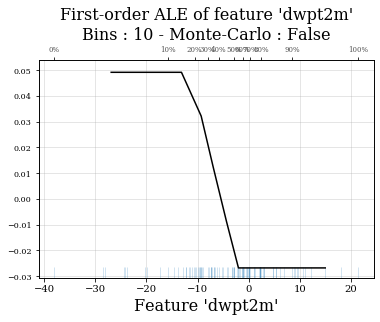

In [8]:
import ale
ale.ale_plot(
    model=model_objs[0],
    train_set=examples,
    features=('dwpt2m'),
    bins=10,
    rugplot_lim=1000,
)

# Accumulated Local Effect

Models for ALE: ['RandomForestClassifier', 'LogisticRegression', 'GradientBoostingClassifier']
Using 3 processors...


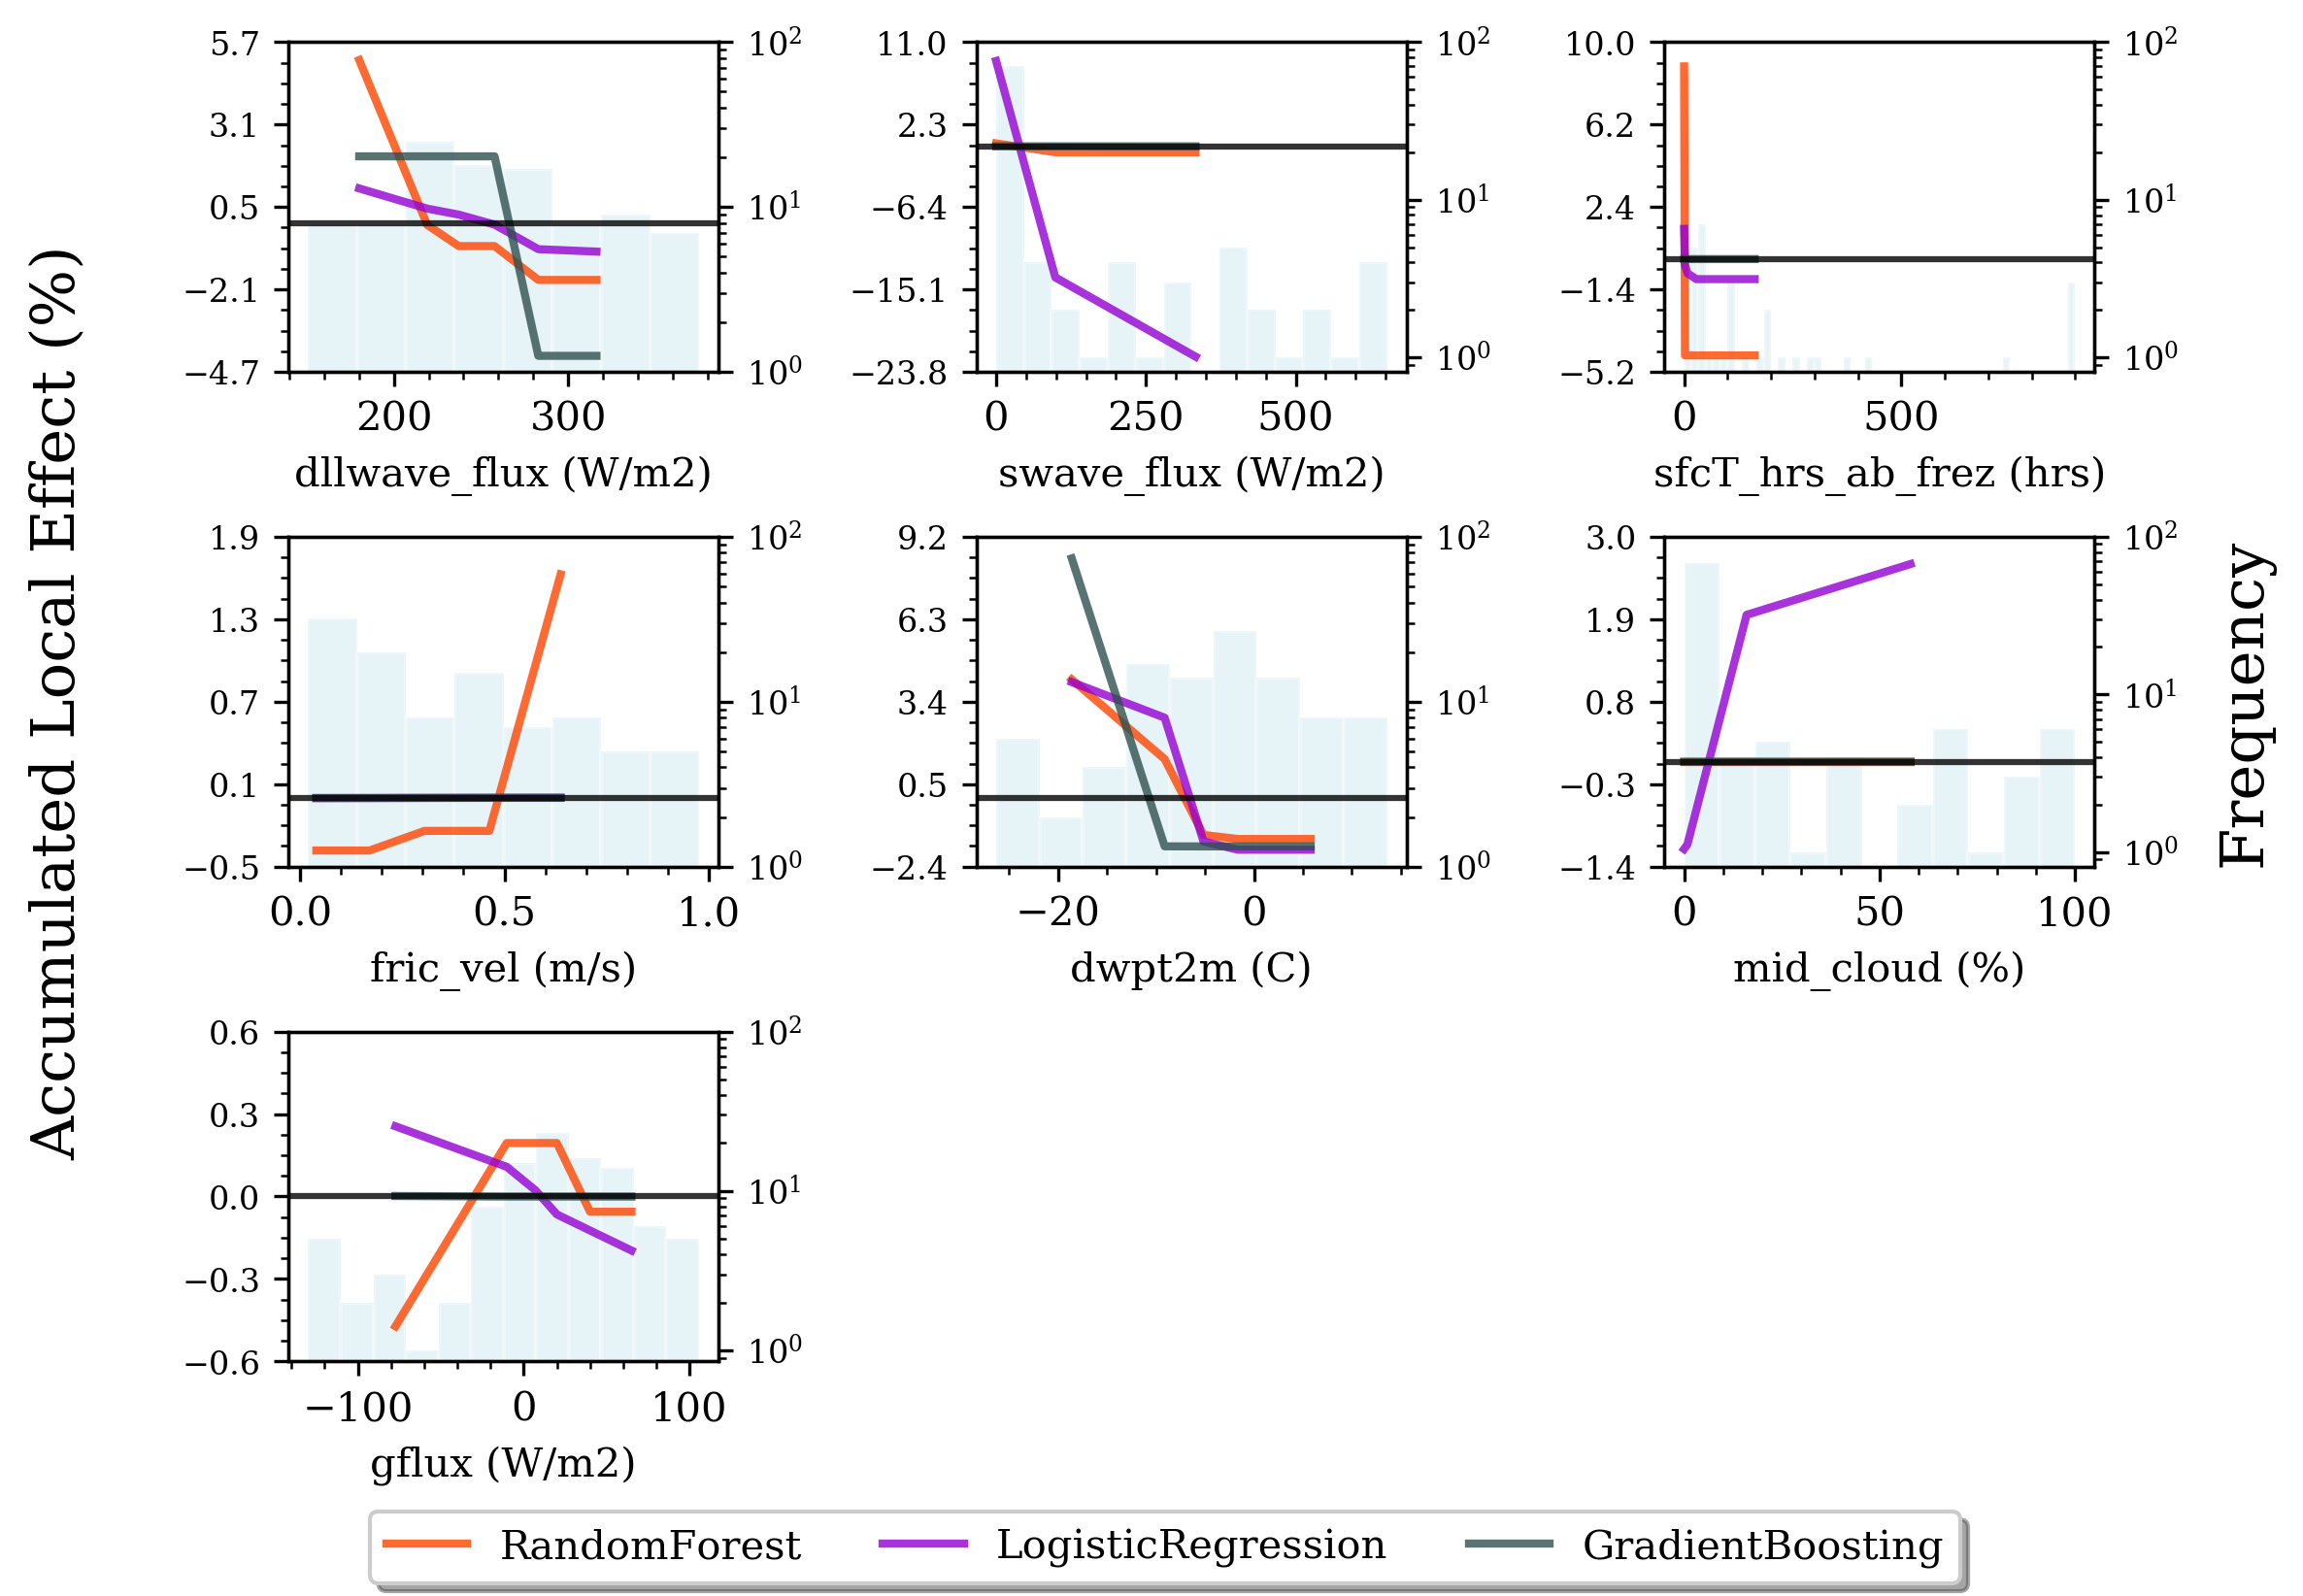

In [9]:
myInterpreter.run_ale(features=important_vars, nbootstrap=1, subsample=1.0, njobs=3)
fig, axes = myInterpreter.plot_ale(feature_units=feature_units)

# Feature Contributions (Random Forest Only)

For random forest, it is possible to breakdown a prediction into a series of contributions from the predictors. 

In [10]:
out_dict = myInterpreter.run_tree_interpreter(performance_based=True, n_examples=100)

Processing hits...
Interpreting 36 examples...
Processing misses...
Interpreting 36 examples...
Processing false_alarms...
Interpreting 64 examples...
Processing corr_negs...
Interpreting 64 examples...
LogisticRegression is not accepted for this method. Passing...
GradientBoostingClassifier is not accepted for this method. Passing...


hits
misses
false_alarms
corr_negs


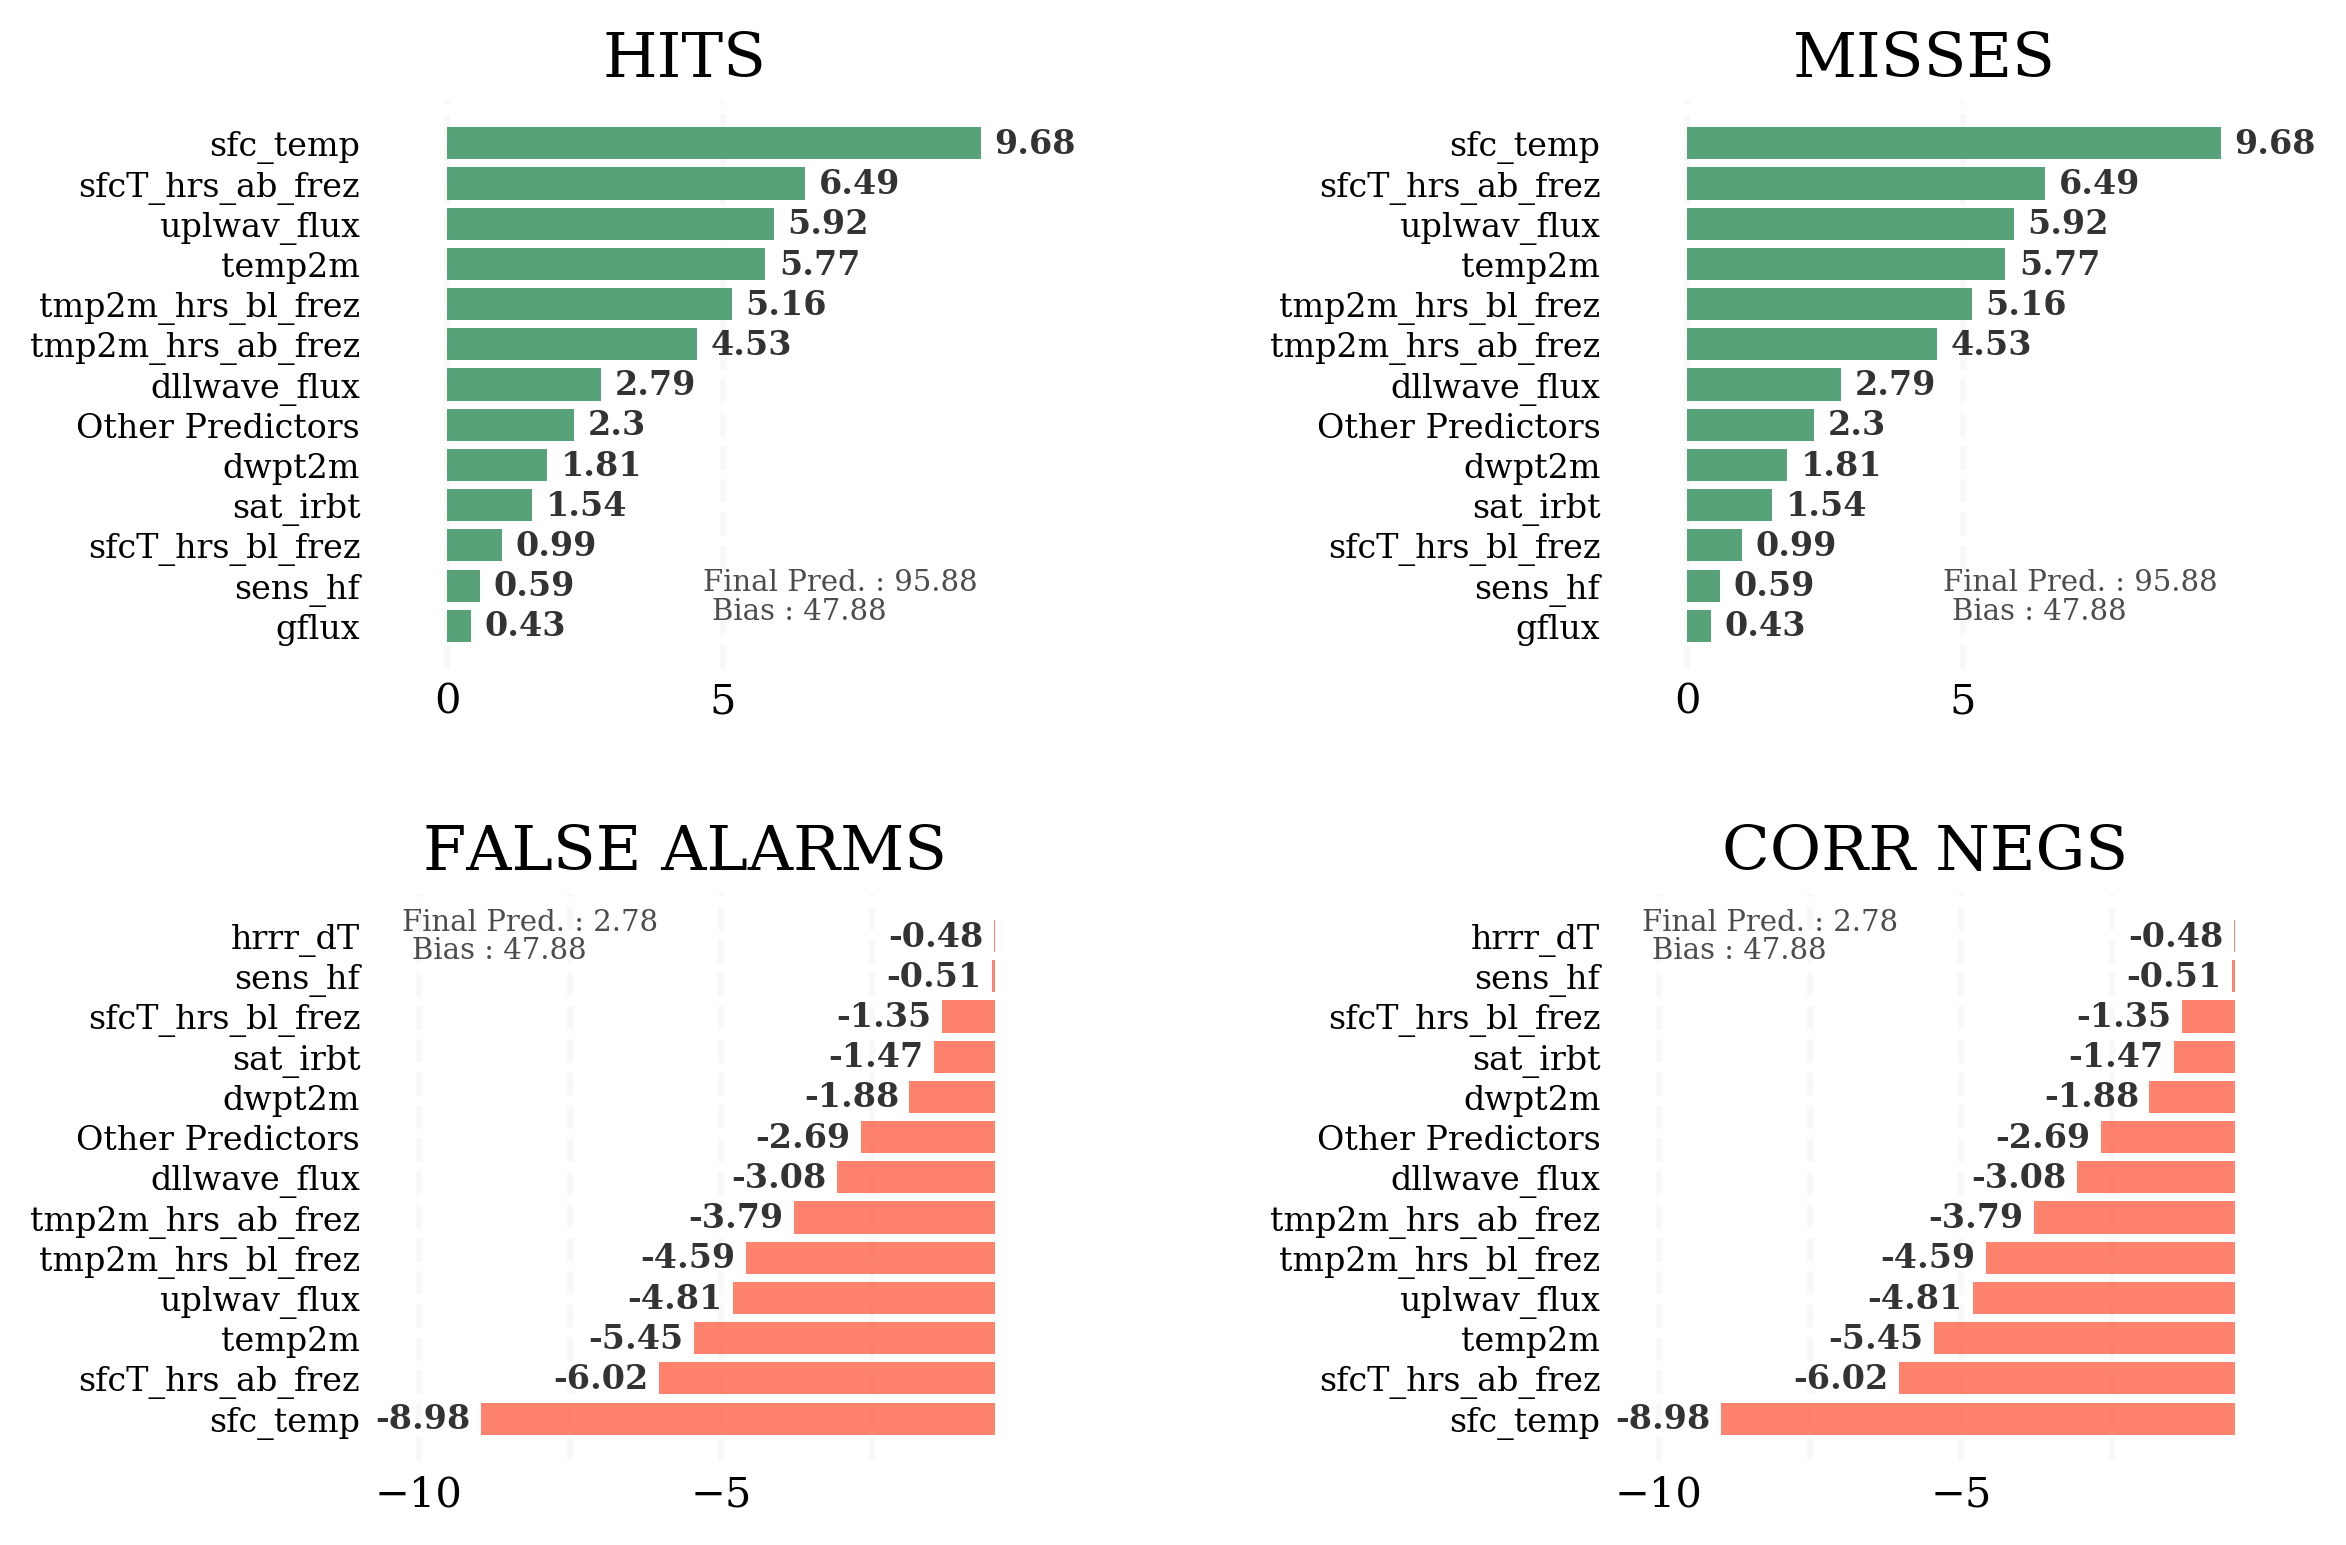

In [11]:
fig = myInterpreter.plot_tree_interpreter()

# Fix the positioning of the Final Pred. and Bias!!!
# Fix the position of the end-bar numbers (especially for negative numbers)

In [12]:
# Second-order PDP and ALE 

# Saving the figures
c_plot.save_figure(fig, fname, bbox_inches="tight", dpi=300, aformat="png")